In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [5]:
#We read the datafile.
    #Period < 1 day
    #Planet Radius = not null
    #Stellar Effective Temperature = not null
    #Stellar Radius = not null
    #K Mag (2MASS) = not null
    
df = pd.read_csv('../../data/toi2431_extra/ESM_and_TSM_USPs.csv', comment = "#")

df

,pl_name,hostname,default_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,...,sy_vmagerr2,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2
0,ZTF J1828+2308 b,ZTF J1828+2308,1,0.112007,8.700000e-07,-8.700000e-07,0,NaN,NaN,NaN,...,-0.0459,NaN,NaN,NaN,NaN,NaN,NaN,18.0258,0.001293,-0.001293
1,KOI-1843.03,Kepler-974,1,0.176891,2.000000e-07,-2.000000e-07,0,NaN,NaN,NaN,...,-0.0580,11.951,0.021,-0.021,11.056,0.017,-0.017,14.4126,0.000483,-0.000483
2,K2-137 b,K2-137,1,0.179719,2.800000e-05,-2.800000e-05,0,NaN,NaN,NaN,...,-0.2000,11.764,0.026,-0.026,10.882,0.023,-0.023,14.4345,0.000618,-0.000618
3,ZTF J1230-2655 b,ZTF J1230-2655,1,0.235978,9.500000e-07,-9.500000e-07,0,NaN,NaN,NaN,...,-0.0460,NaN,NaN,NaN,NaN,NaN,NaN,18.8866,0.002415,-0.002415
4,TOI-6255 b,TOI-6255,1,0.238182,1.200000e-07,-1.200000e-07,0,NaN,NaN,NaN,...,-0.0520,8.912,0.026,-0.026,8.071,0.020,-0.020,11.6345,0.000929,-0.000929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,HIP 65 A b,HIP 65 A,1,0.980973,3.100000e-06,-3.100000e-06,0,0.01782,0.0002,-0.00021,...,-0.0300,8.922,0.019,-0.019,8.290,0.025,-0.025,10.5895,0.000446,-0.000446
142,Kepler-1258 b,Kepler-1258,1,0.984940,3.182000e-06,-3.182000e-06,0,NaN,NaN,NaN,...,-0.0800,12.763,0.029,-0.029,12.382,0.026,-0.026,13.7847,0.000220,-0.000220
143,Kepler-80 f,Kepler-80,1,0.986787,6.000000e-08,-6.000000e-08,0,0.01750,0.0002,-0.00020,...,-0.1720,12.954,0.023,-0.023,12.253,0.020,-0.020,14.7555,0.000492,-0.000492
144,TOI-1634 b,TOI-1634,1,0.989345,6.000000e-06,-6.000000e-06,0,NaN,NaN,NaN,...,-0.0430,9.484,0.021,-0.021,8.600,0.014,-0.014,12.1965,0.000268,-0.000268


In [6]:
#We calculate the semi major axis of each planet as a double check & to avoid NaN values.
def calc_semi_major(period_days, stellar_mass):
    #We first convert period from days to years.
    period_years = period_days/365.25
    
    #We use Kepler's 3rd Law.
    #Depending on whether the Stellar Mass exists or not, we can either calculate the semi major axis very well or
    #estimate it.
    #We first calculate the semi major axis if stellar mass exists.
    if not np.isnan(stellar_mass):
        semi_major_axis = (period_years ** 2 * stellar_mass) ** (1/3)

    #If the stellar mass does not exist, we calculate an estimate.
    elif np.isnan(stellar_mass):
        semi_major_axis = (period_years ** 2) ** (1/3)

    #We return the semi_major_axis in units of AU.
    return semi_major_axis

#We calculate the semi major axis values.
period_list = list(df["pl_orbper"])
mass_list = list(df["st_mass"])
semi_major = list()

for i, per in enumerate(period_list):
    semi_major_value = calc_semi_major(per, mass_list[i])
    print(f"{semi_major_value} AU")
    semi_major.append(semi_major_value)

0.0038566698550542605 AU
0.0047606191936973175 AU
0.006232598907287241 AU
0.006460477472354637 AU
0.005314608103304909 AU
0.005984575347516755 AU
0.005397044459498999 AU
0.007471220206972878 AU
0.0070704089987342865 AU
0.0075892889638681715 AU
0.009732744459685999 AU
0.009809889827834392 AU
0.009028396994217881 AU
0.009619133392583513 AU
0.009363413791013499 AU
0.006367013127824462 AU
0.010286760682314901 AU
0.008333542486735427 AU
0.007138428965168752 AU
0.008050063012545686 AU
0.010772204531280716 AU
0.005850171399760645 AU
0.006236513104217675 AU
0.011818552774407633 AU
0.011639826662350082 AU
0.01119772697886661 AU
0.012420165433278204 AU
0.009153733711726023 AU
0.012333830000047433 AU
0.013163814237806201 AU
0.012243812457918828 AU
0.011856712702459834 AU
0.012210861646649165 AU
0.012833992882019259 AU
0.012510103853796117 AU
0.012627290013236071 AU
0.013457773817097259 AU
0.012810013959523258 AU
0.013072120071013434 AU
0.009994650199486298 AU
0.012491290722221412 AU
0.01359003758

In [7]:
#We take the names, period, planet and stellar radius, stellar effective temperature, K magnitudes, and J magnitudes.
names = list(df["pl_name"])
period = list(df["pl_orbper"])
pl_mass = list(df["pl_bmasse"])
pl_radius = list(df["pl_rade"])
st_radius = list(df["st_rad"])
eff_temp = list(df["st_teff"])
#semi_major = list(df["pl_orbsmax"])
k_mag = list(df["sy_kmag"])
j_mag = list(df["sy_jmag"])

#We can also add the values TOI-2431b has to our lists.
# names.append("TOI-2431 b")
# period.append(0.2241957774) #days
# pl_radius.append(1.53) #Earth Radii
# st_radius.append(0.66) #Solar Radii
# eff_temp.append(4122) #K
# semi_major.append(0.006) #AU
# k_mag.append(7.554) #mag
names.append("TOI-2431 b")
period.append(0.2241957774) #days
pl_mass.append(6.2) #Earth Masses
pl_radius.append(1.4431) #Earth Radii
st_radius.append(0.626) #Solar Radii
eff_temp.append(4131) #K
semi_major.append(0.006) #AU
k_mag.append(7.554) #mag
j_mag.append(8.36) #mag

#We also add TOI-6324b, which is a newly discovered exoplanet that is not in the archive yet.
# names.append("TOI-6324 b")
# period.append(0.2792210) #days
# pl_mass.append(1.17) #Earth Masses
# pl_radius.append(1.059) #Earth Radii
# st_radius.append(0.293) #Solar Radii
# eff_temp.append(3247.0) #K
# semi_major.append(3.17*0.293*696340000/149597870700) #AU
# k_mag.append(8.691) #mag
# j_mag.append(9.41) #mag

#We add the new planet on the archive, KOI 1843.03
# names.append("KOI-1843.03")
# period.append(0.1768913) #days
# pl_mass.append(None) #Earth Masses (Since there is only a limit on the mass, < 8, we keep it None.)
# pl_radius.append(0.61) #Earth Radii
# st_radius.append(0.45) #Solar Radii
# eff_temp.append(3584) #K
# semi_major.append(1.9*0.45*696340000/149597870700) #AU
# k_mag.append(11.056) #mag
# j_mag.append(11.951) #mag

In [8]:
#We then calculate the ESM of TOI-2431.01 ourselves.
#First, we have to define a Planck Function.
def Planck_function(wavelength, T):
    """Takes the Temperature. Calculates the Planck Function for given 
    Wavelength and Temperature.
    
    Input:
    ----------------------------------------------------------------------------
    wavelength: Wavelength in meters (Example: 7.5 μm -> 7.5e-6)
    T: Temperature in Kelvin
    
    Output:
    ----------------------------------------------------------------------------
    result: Spectral Radiance in [W/m^3]
    
    """

    #We define the constants of the Planck Function. (SI Units)
    h = 6.62607015e-34  #Planck's constant in [J * s]
    c = 3.0e8           #Speed of light in [m/s]
    k_B = 1.380649e-23  #Boltzmann constant in [J/K]

    #We calculate the Planck Function.
    #For that, we split the formula into different terms from planck 1 to planck 3.
    planck1 = 2 * h * c**2
    planck2 = wavelength ** 5
    planck3 = (h * c) / (wavelength * k_B * T)

    #We calculate the result.
    result = planck1 / (planck2 * (np.exp(planck3) - 1))

    return result

#Then we have to define a Equilibrium Temperature calculator function.
def Equilibrium_Temperature(Teff, Rs, a, f, AB):
    """Takes the Effective (Teff) Temperature of the host star, radius of the 
    Star, Orbital Distance, Day-to-Night Side Heat redistribution and Bond Albedo.
    Returns the Equilibrium Temperature in Kelvin.
    
    Input:
    ----------------------------------------------------------------------------
    Teff: Effective Temperature of the Host Star in Kelvin.
    Rs: Stellar Radius in meters.
    a: Orbital Distance/Semi-Major Axis in meters.
    f: Day-to-Night Side Heat redistribution
    AB: Bond Albedo, bolometric fraction of incident energy that is absorbed
    
    
    Output:
    ----------------------------------------------------------------------------
    result: Equilibrium Temperature in Kelvin.
    
    """

    #We split the formula into different terms from Teq1 to Teq4.
    Teq1 = Teff
    Teq2 = Rs/(2*a)
    Teq3 = f * (1 - AB)

    #We calculate the result.
    result = Teq1 * (Teq2 ** (1/2)) * (Teq3 ** (1/4))

    return result

def ESM_calculator(Teff, Tday, Rp, Rs, mk):
    """Takes the Effective (Teff) Temperature of the host star, Dayside (Tday) 
    Temperature of the planet, the radius of the Planet and the Star and 
    apparent magnitude of the host star in the K Band. Returns the ESM 
    (Emission Spectroscopy Metric) value.
    
    Input:
    ----------------------------------------------------------------------------
    Teff: Effective Temperature of the Host Star in Kelvin.
    Tday: Dayside Temperature of the Planet in Kelvin. (Can be calculated by 
    1.1 times the Equilibrium Temperature of the Planet)
    Rp: Planet Radius in meters.
    Rs: Stellar Radius in meters.
    mk: Apparent magnitude of the host star in the K band.
    
    
    Output:
    ----------------------------------------------------------------------------
    result: ESM (Emission Spectroscopy Metric)
    
    """
    
    #We split the formula into different terms from ESM1 to ESM4.
    ESM1 = 4.29e6
    ESM2 = Planck_function(7.5e-6, Tday) / Planck_function(7.5e-6, Teff)
    ESM3 = (Rp/Rs) ** 2
    ESM4 = 10 ** (-mk/5)

    #We calculate the result.
    result = ESM1 * ESM2 * ESM3 * ESM4

    return result

In [9]:
#We can then calculate the Equilibrium Temperature first.
#NOTE: When calculating the Equilibrium Temperature on this code, zero bond albedo and full day-night heat 
#redistribution is assumed.
#Then we will calculate the Dayside Temperature by multiplying it with 1.1!
    #Teff: Taken from ExoFOP.
    #Rs: Taken from ExoFOP.
    #a: Taken from ExoFOP.
    #f: Taken as 1.
    #AB: Taken as 0.
Teq_toi2431 = Equilibrium_Temperature(4122, 0.66*696340000, 0.006*149597870700, 1, 0)
Tday_toi2431 = Teq_toi2431 * 1.1

print(80 * "-")
print(f"Equilibrium Temperature of TOI-2431b: {Teq_toi2431} Kelvin")
print(f"Dayside Temperature of TOI-2431b: {Tday_toi2431} Kelvin")
print(80 * "-")

#We can finally calculate the ESM value of TOI-2431b.
    #Teff: Taken from ExoFOP.
    #Tday: Calculated.
    #Rp: From Transit analysis.
    #Rs: Taken from ExoFOP.
    #mk: Taken from ExoFOP
ESM_toi2431 = ESM_calculator(4122, Tday_toi2431, 1.53*6378137, 0.66*696340000, 7.5540)
print(80 * "-")
print(f"ESM of TOI-2431b: {ESM_toi2431}")
print(80 * "-")

--------------------------------------------------------------------------------
Equilibrium Temperature of TOI-2431b: 2085.6301564962505 Kelvin
Dayside Temperature of TOI-2431b: 2294.193172145876 Kelvin
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
ESM of TOI-2431b: 27.037653463754072
--------------------------------------------------------------------------------


In [10]:
# ------------------------- ESM CALCULATION WITH ERROR ---------------------------
#We first define a function to obtain the median, upper and lower error values from a vector.
def get_vals(vec):
    fvec   = np.sort(vec)

    fval  = np.median(fvec)
    nn = int(np.around(len(fvec)*0.15865))

    vali,valf = fval - fvec[nn],fvec[-nn] - fval
    return fval,vali,valf

#We can then calculate the Equilibrium Temperature first.
#NOTE: When calculating the Equilibrium Temperature on this code, zero bond albedo and full day-night heat 
#redistribution is assumed.
#Then we will calculate the Dayside Temperature by multiplying it with 1.1!
    #Teff: Taken from SED Fit.
    #Rs: Taken from SED and RV-LC Joint Fit.
    #a: Taken from RV-LC Joint Fit.
    #f: Taken as 1.
    #AB: Taken as 0.
Teq_toi2431_vector = Equilibrium_Temperature(np.random.normal(4122, 40, 30000),
                                             np.random.normal(0.66*696340000, 0.01*696340000, 30000),
                                             np.random.normal(0.006*149597870700, 1e-4*149597870700, 30000),
                                             np.full(30000,1),
                                             np.full(30000,0))

Teq_toi2431_val, Teq_toi2431_down, Teq_toi2431_up = get_vals(Teq_toi2431_vector)

#We calculate the dayside temperature.
Tday_toi2431_vector = Teq_toi2431_vector * 1.1

Tday_toi2431_val, Tday_toi2431_down, Tday_toi2431_up = get_vals(Tday_toi2431_vector)

print(80 * "-")
print(f"Equilibrium Temperature of TOI-2431b: {Teq_toi2431_val:.4f} +{Teq_toi2431_up:.4f} -{Teq_toi2431_down:.4f} Kelvin")
print(f"Dayside Temperature of TOI-2431b: {Tday_toi2431_val:.4f} +{Tday_toi2431_up:.4f} -{Tday_toi2431_down:.4f} Kelvin")
print(80 * "-")

#We can finally calculate the ESM value of TOI-2431b.
    #Teff: Taken from SED Fit.
    #Tday: Calculated.
    #Rp: Taken from RV-LC Joint Fit.
    #Rs: Taken from RV-LC Joint Fit.
    #mk: Taken from SED Fit.
ESM_toi2431_vector = ESM_calculator(np.random.normal(4122, 40, 30000),
                                    Tday_toi2431_vector,
                                    np.random.normal(1.53*6378137, 0.03*6378137, 30000),
                                    np.random.normal(0.66*696340000, 0.01*696340000, 30000),
                                    np.random.normal(7.5540, 0.0230, 30000))

ESM_toi2431_val, ESM_toi2431_down, ESM_toi2431_up = get_vals(ESM_toi2431_vector)

print(80 * "-")
print(f"ESM of TOI-2431b: {ESM_toi2431_val} +{ESM_toi2431_up} -{ESM_toi2431_down}")
print(80 * "-")

--------------------------------------------------------------------------------
Equilibrium Temperature of TOI-2431b: 2085.7004 +31.3964 -30.6966 Kelvin
Dayside Temperature of TOI-2431b: 2294.2704 +34.5360 -33.7663 Kelvin
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
ESM of TOI-2431b: 27.05146855711417 +1.5786205186334357 -1.5168248847948895
--------------------------------------------------------------------------------


In [11]:
#We can then calculate the Equilibrium Temperature first.
#NOTE: When calculating the Equilibrium Temperature on this code, zero bond albedo and full day-night heat 
#redistribution is assumed.
#Then we will calculate the Dayside Temperature by multiplying it with 1.1!
    #Teff: Taken from ExoFOP.
    #Rs: Taken from ExoFOP.
    #a: Taken from ExoFOP.
    #f: Taken as 1.
    #AB: Taken as 0.
# Teq_toi6324 = Equilibrium_Temperature(3247, 0.293*696340000, calc_semi_major(0.2792210, 0.269)*149597870700, 1, 0)
Teq_toi6324 = Equilibrium_Temperature(3247, 
                                      0.293*696340000, 
                                      (3.17*0.293*696340000),
                                      1,
                                      0.1)
Tday_toi6324 = Teq_toi6324 * 1.1

print(80 * "-")
print(f"Equilibrium Temperature of TOI-6234b: {Teq_toi6324} Kelvin")
print(f"Dayside Temperature of TOI-6324b: {Tday_toi6324} Kelvin")
print(80 * "-")

#We can finally calculate the ESM value of TOI-2431b.
    #Teff: Taken from ExoFOP.
    #Tday: Calculated.
    #Rp: From Transit analysis.
    #Rs: Taken from ExoFOP.
    #mk: Taken from ExoFOP
ESM_toi6324 = ESM_calculator(3247, Tday_toi6324, 1.059*6378137, 0.293*696340000, 8.691)
print(80 * "-")
print(f"ESM of TOI-6324b: {ESM_toi6324}")
print(80 * "-")

--------------------------------------------------------------------------------
Equilibrium Temperature of TOI-6234b: 1256.0250096402062 Kelvin
Dayside Temperature of TOI-6324b: 1381.627510604227 Kelvin
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
ESM of TOI-6324b: 22.99074394220859
--------------------------------------------------------------------------------


In [12]:
#We create a list to contain the calculated Day-side Temperature, Equilibrium Temperature and ESM values of USPs.
ESM = []
Teq = []
Tday = []

#We calculate the ESM values.
for i,planet in enumerate(names):
    #We get the information about the current planet we are looking at.
    current_name = names[i]
    current_period = period[i]
    current_pl_radius = pl_radius[i]
    current_st_radius = st_radius[i]
    current_eff_temp = eff_temp[i]
    current_semi_major = semi_major[i]
    current_k_mag = k_mag[i]

    #We calculate the ESM as follows.
    current_Teq = Equilibrium_Temperature(current_eff_temp, 
                                          current_st_radius * 696340000, 
                                          current_semi_major * 149597870700, 
                                          1, 0)
    current_Tday = current_Teq * 1.1

    current_ESM = ESM_calculator(current_eff_temp, 
                                 current_Tday, 
                                 current_pl_radius * 6378137, 
                                 current_st_radius * 696340000, 
                                 current_k_mag)

    #We add the ESM to the list.
    ESM.append(current_ESM)
    Tday.append(current_Tday)
    Teq.append(current_Teq)

#We also add TOI-2431b's ESM.
print(ESM)
print(sorted(Teq))

[nan, 1.5796555582329228, 2.4863955373999795, nan, 21.952668680070648, 1.143731820487193, 19.587466259522742, 14.940374909081019, 16.42426839509188, 1.3059230195395592, 8.600773400507002, 1.234809792525331, 4.344183789875434, 1.1189439892212856, 6.646910298624389, 9.772781192036051, 6.067877774381512, 12.998152808667857, 9.138315251097543, 0.4163064345075092, 6.348931088961191, 3.7154892519247884, 29.011867443035904, 1.302108646219941, 5.082134553576348, 15.974079994432087, 1.2047073329414544, 16.41994104825558, 0.966405083072328, 0.7464817954983181, 0.36952361891354096, 8.513209115136021, 13.565000709175273, 0.9162268426601075, 1.0809734299985658, 0.9652962871721198, 1.1723245007811003, 1.1541172132027553, 3.2673682700953353, 12.523255459304654, 1.2941667303340214, 0.7259255247099916, 2.682258578309791, 1.0404321576596702, 11.818137931101298, 1.0683933190350956, 1.740171889731905, 0.7345630645087645, 0.42567061025243674, 0.4189041647660518, 0.15692464612670218, 0.0562152660637484, 13.

In [13]:
#Now we have to do the plotting.
#For that, first we create a colormap based on the Temperature values.
norm = plt.Normalize(vmin = min(Teq), vmax = max(Teq))
cmap = plt.get_cmap("coolwarm")

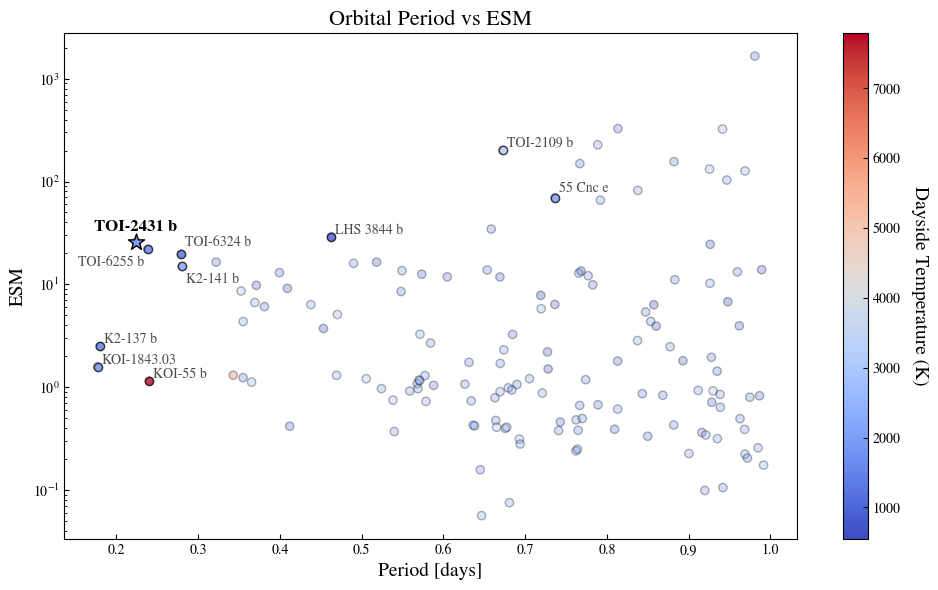

In [14]:
#We then plot the results.
plt.figure(figsize=(10, 6))

scatter = plt.scatter(period, ESM, c = Teq, cmap = cmap, edgecolors = "k", norm = norm, zorder = 3, alpha = 0.3)
cbar = plt.colorbar(scatter)
cbar.set_label('Dayside Temperature (K)', rotation=270, labelpad=20, fontsize = 14)
cbar.solids.set_alpha(1)

#Now we also add labels to each datapoint.
for i, txt in enumerate(names):
    # if txt != "--":
    if txt != "--" and (txt == "K2-137 b" or txt == "K2-141 b" or txt == "TOI-6255 b" or txt == "KOI-55 b" or 
                        txt == "LHS 3844 b" or txt == "55 Cnc e" or txt == "TOI-2109 b" or txt == "TOI-6324 b" or
                        txt == "KOI-1843.03" or txt == "TOI-2431 b"):
        
        if txt == "K2-141 b":
            plt.text(period[i]+0.005, ESM[i]-2.0, txt, fontsize = 10, ha='left', va='top', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7)

        elif txt == "55 Cnc e":
            plt.text(period[i]+0.005, ESM[i]+4.5, txt, fontsize = 10, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7)

        elif txt == "TOI-6255 b":
            plt.text(period[i]-0.085, ESM[i]-8, txt, fontsize = 10, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7)
            
        elif txt == "TOI-6324 b":
            plt.text(period[i]+0.005, ESM[i]+2.5, txt, fontsize = 10, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7)
            
        elif txt == "TOI-2431 b":
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        marker = "*", norm = norm, zorder = 4, alpha = 1.0, s = 150)
            plt.text(period[i]+0.05, ESM[i]+5, txt, fontsize = 12, ha='right', va='bottom', zorder = 5, weight = "bold", alpha = 1.0)
        
        else:
            plt.text(period[i]+0.005, ESM[i], txt, fontsize = 10, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7)
        # if txt == "TOI-6255 b":
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.5)
        # else:
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 4, alpha = 0.5)

#We add the labels and title
plt.title("Orbital Period vs ESM", fontsize = 16)
plt.xlabel("Period [days]", fontsize = 14)
plt.ylabel("ESM", fontsize = 14)
# plt.xscale("log")
plt.yscale("log")
# plt.grid(True, zorder = 1)
plt.tight_layout()
plt.savefig("ESM_plot", dpi = 500)
plt.show()

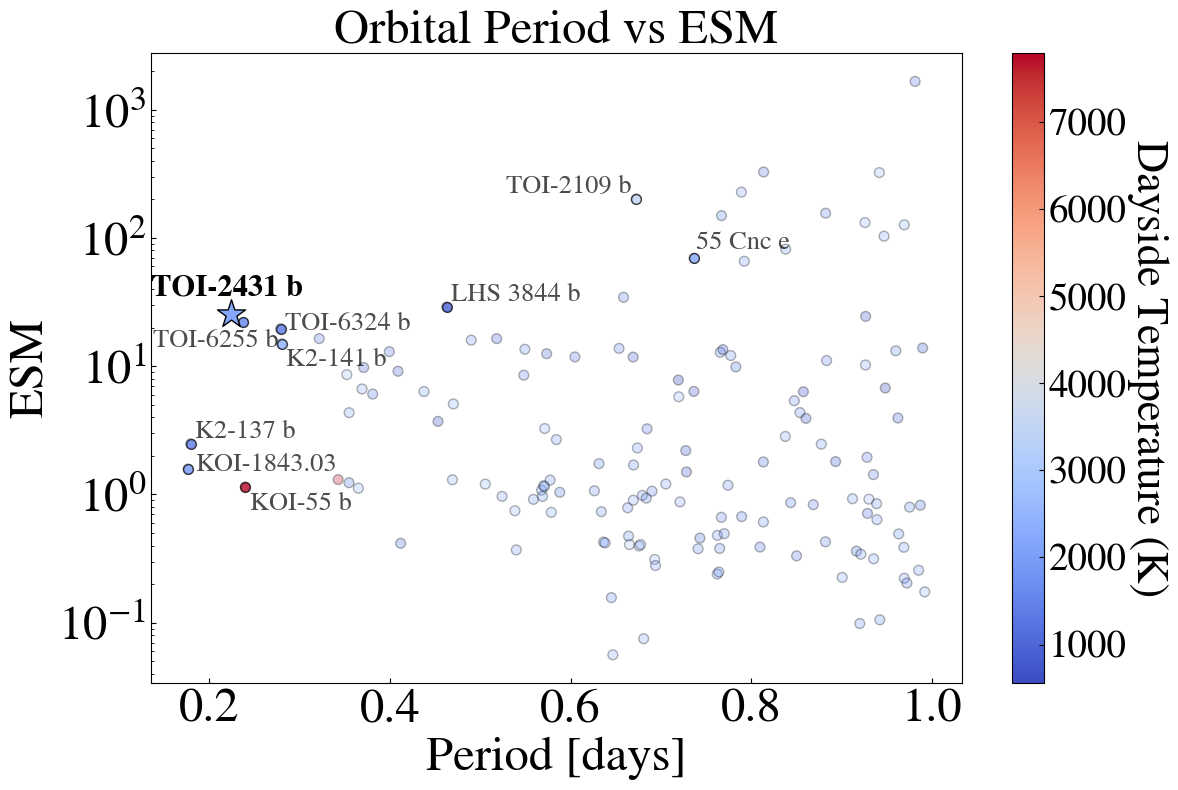

In [15]:
#We then plot the results.
plt.figure(figsize=(12, 8))

scatter = plt.scatter(period, ESM, c = Tday, cmap = cmap, edgecolors = "k", norm = norm, zorder = 3, alpha = 0.3, s = 50)
cbar = plt.colorbar(scatter)
cbar.set_label('Dayside Temperature (K)', rotation=270, labelpad=30, fontsize = 32)
cbar.solids.set_alpha(1)
cbar.ax.tick_params(labelsize = 28)

#Now we also add labels to each datapoint.
for i, txt in enumerate(names):
    # if txt != "--":
    if txt != "--" and (txt == "K2-137 b" or txt == "K2-141 b" or txt == "TOI-6255 b" or txt == "KOI-55 b" or 
                        txt == "LHS 3844 b" or txt == "55 Cnc e" or txt == "TOI-2109 b" or txt == "TOI-6324 b" or
                        txt == "KOI-1843.03" or txt == "TOI-2431 b"):
        
        if txt == "K2-141 b":
            plt.text(period[i]+0.005, ESM[i]-1.0, txt, fontsize = 19, ha='left', va='top', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "55 Cnc e":
            plt.text(period[i]+0.002, ESM[i]+4.5, txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "TOI-2109 b":
            plt.text(period[i]-0.005, ESM[i], txt, fontsize = 19, ha='right', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "TOI-6255 b":
            plt.text(period[i]-0.1, ESM[i]-9.3, txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)
            
        elif txt == "TOI-6324 b":
            plt.text(period[i]+0.005, ESM[i]-2.3, txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "KOI-1843.03":
            plt.text(period[i]+0.008, ESM[i]-0.2, txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "KOI-55 b":
            plt.text(period[i]+0.005, ESM[i]-0.46, txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)
        
        elif txt == "TOI-2431 b":
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        marker = "*", norm = norm, zorder = 4, alpha = 1.0, s = 450)
            plt.text(period[i]+0.08, ESM[i]+6, txt, fontsize = 22, ha='right', va='bottom', zorder = 5, weight = "bold", alpha = 1.0)
        
        else:
            plt.text(period[i]+0.005, ESM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], ESM[i], c = [Tday[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)
        # if txt == "TOI-6255 b":
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.5)
        # else:
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 4, alpha = 0.5)

#We add the labels and title
plt.title("Orbital Period vs ESM", fontsize = 35)
plt.xlabel("Period [days]", fontsize = 35)
plt.ylabel("ESM", fontsize = 35)
# plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis = 'both', labelsize = 35)
# plt.grid(True, zorder = 1)
plt.tight_layout()
plt.savefig("ESM_plot", dpi = 500)
plt.show()

In [16]:
#TSM calculation
def TSM_calculator(Teq, Mp, Rp, Rs, mj):
    """Takes the equilibrium temperature of the Star, mass of the Planet, 
    the radius of the Planet and the Star and apparent magnitude of the host 
    star in the J Band. Returns the TSM (Transmission Spectroscopy Metric) value.
    
    Input:
    ----------------------------------------------------------------------------
    Teq: Equilibrium Temperature of the Host Star in Kelvin. (f = 1 and AB = 0)
    Mp: Planet Mass in Earth masses.
    Rp: Planet Radius in Earth radii.
    Rs: Stellar Radius in solar radii.
    mk: Apparent magnitude of the host star in the K band.
    
    
    Output:
    ----------------------------------------------------------------------------
    result: TSM (Transmission Spectroscopy Metric)
    
    """
    
    #We split the formula into different terms from ESM1 to ESM4.
    TSM1 = Rp**3 * Teq
    TSM2 = Mp * Rs**2
    TSM3 = 10 ** (-mj/5)

    #We calculate the Scale Factor of TSM according to the stellar radius.
    if Rp < 1.5:
        TSM4 = 0.190

    elif Rp < 2.75 and Rp > 1.5:
        TSM4 = 1.26

    elif Rp < 4.0 and Rp > 2.75:
        TSM4 = 1.26

    elif Rp < 10 and Rp > 4:
        TSM4 = 1.15

    else:
        TSM4 = np.nan #TSM is not defined for these planets.

    #We calculate the result.
    result = TSM4 * (TSM1/TSM2) * TSM3

    return result

In [17]:
#Now we can calculate the TSM for all of the USPs.
#We create a list to contain the calculated Day-side Temperature, Equilibrium Temperature and ESM values of USPs.
TSM = []

#We calculate the TSM values.
for i,planet in enumerate(names):
    #We get the information about the current planet we are looking at.
    current_name = names[i]
    current_period = period[i]
    current_pl_mass = pl_mass[i]
    current_pl_radius = pl_radius[i]
    current_st_radius = st_radius[i]
    current_eff_temp = eff_temp[i]
    current_semi_major = semi_major[i]
    current_j_mag = j_mag[i]

    #We calculate the ESM as follows.
    current_Teq = Equilibrium_Temperature(current_eff_temp, 
                                          current_st_radius * 696340000, 
                                          current_semi_major * 149597870700, 
                                          1, 0)

    current_TSM = TSM_calculator(current_Teq, 
                                 current_pl_mass,
                                 current_pl_radius,
                                 current_st_radius,
                                 current_j_mag)

    #We add the ESM to the list.
    TSM.append(current_TSM)

print(TSM)

[nan, 0.18222316914256637, nan, nan, 27.517138898399566, 30.300400086494665, 34.024476157186676, 60.35006326231335, 31.519785405464646, 26.940635083398398, nan, nan, 7.152584791463801, 2.354257218940542, 22.834826750121643, nan, nan, nan, nan, 0.004306467036088152, nan, nan, nan, nan, 5.43951837968759, 15.884693452946324, nan, 31.761037761863463, nan, nan, nan, 15.593735250787466, 20.82838518263825, nan, nan, nan, nan, nan, 12.746285941137108, 13.010884153366412, nan, nan, nan, nan, 29.09225873608022, nan, nan, nan, nan, nan, nan, nan, nan, 147.49432532918982, nan, nan, nan, 12.381716262547307, 0.837703389131225, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 33.25081894813899, nan, nan, nan, nan, 253.6529620709355, nan, nan, nan, nan, nan, nan, 20.66279505034056, nan, nan, 17.99237185025865, nan, nan, 12.519570648280924, nan, nan, nan, 184.5202360936769, nan, nan, nan, nan, 3.7607722829772077, nan, nan, 17.60933893033115, nan, 33.5244983370884, 5.133364147328155

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


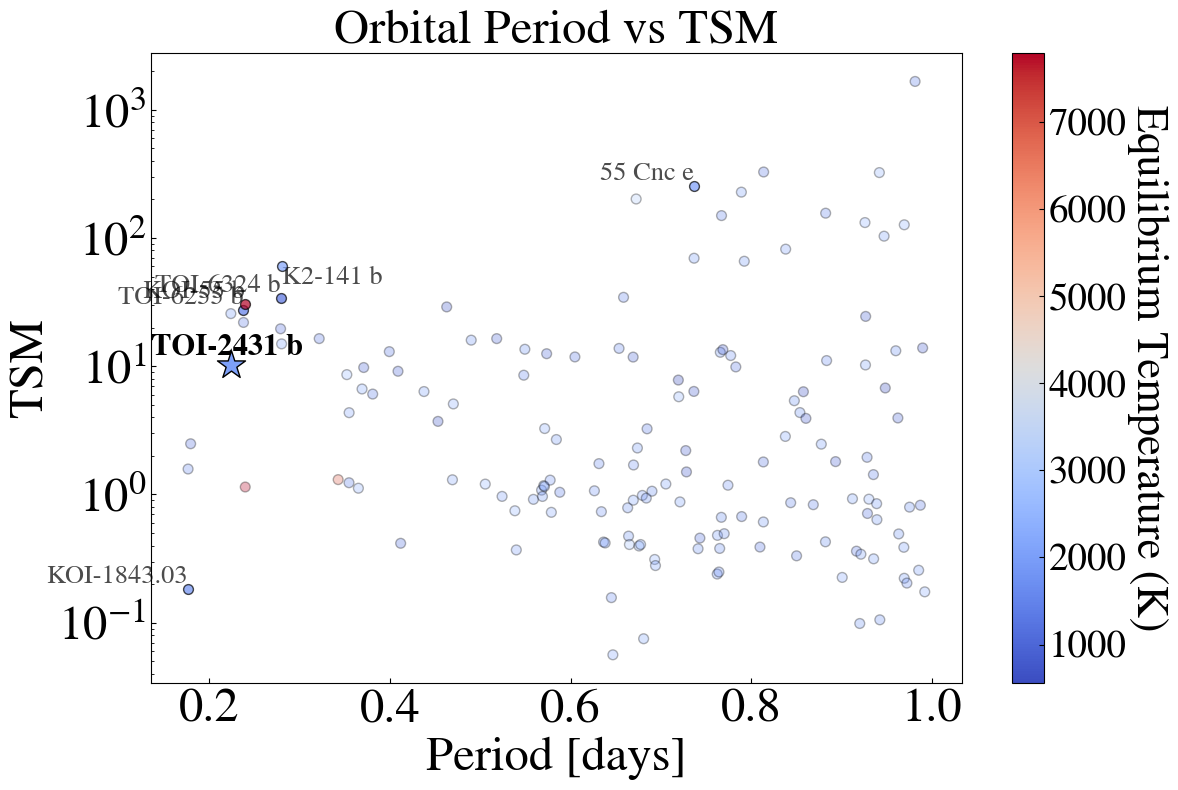

In [18]:
#We plot the TSM values.
#We then plot the results.
plt.figure(figsize=(12, 8))

scatter = plt.scatter(period, ESM, c = Teq, cmap = cmap, edgecolors = "k", norm = norm, zorder = 3, alpha = 0.3, s = 50)
cbar = plt.colorbar(scatter)
cbar.set_label('Equilibrium Temperature (K)', rotation=270, labelpad=30, fontsize = 32)
cbar.solids.set_alpha(1)
cbar.ax.tick_params(labelsize = 28)

#Now we also add labels to each datapoint.
for i, txt in enumerate(names):
    # if txt != "--":
    if txt != "--" and (txt == "K2-137 b" or txt == "K2-141 b" or txt == "TOI-6255 b" or txt == "KOI-55 b" or 
                        txt == "LHS 3844 b" or txt == "55 Cnc e" or txt == "TOI-2109 b" or txt == "TOI-6324 b" or
                        txt == "KOI-1843.03" or txt == "TOI-2431 b"):
        
        if txt == "K2-141 b":
            plt.text(period[i], TSM[i], txt, fontsize = 19, ha='left', va='top', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        # elif txt == "55 Cnc e":
        #     plt.text(period[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
        #     plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
        #                 norm = norm, zorder = 4, alpha = 0.7, s = 50)

        # elif txt == "TOI-2109 b":
        #     plt.text(period[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
        #     plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
        #                 norm = norm, zorder = 4, alpha = 0.7, s = 50)

        # elif txt == "TOI-6255 b":
        #     plt.text(period[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
        #     plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
        #                 norm = norm, zorder = 4, alpha = 0.7, s = 50)
            
        # elif txt == "TOI-6324 b":
        #     plt.text(period[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
        #     plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
        #                 norm = norm, zorder = 4, alpha = 0.7, s = 50)

        # elif txt == "KOI-1843.03":
        #     plt.text(period[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
        #     plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
        #                 norm = norm, zorder = 4, alpha = 0.7, s = 50)

        # elif txt == "KOI-55 b":
        #     plt.text(period[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
        #     plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
        #                 norm = norm, zorder = 4, alpha = 0.7, s = 50)
        
        elif txt == "TOI-2431 b":
            plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        marker = "*", norm = norm, zorder = 4, alpha = 1.0, s = 450)
            plt.text(period[i]+0.08, TSM[i]+1, txt, fontsize = 22, ha='right', va='bottom', zorder = 5, weight = "bold", alpha = 1.0)
        
        else:
            plt.text(period[i], TSM[i], txt, fontsize = 19, ha='right', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(period[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)
        # if txt == "TOI-6255 b":
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.5)
        # else:
        #     plt.text(period[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 4, alpha = 0.5)

#We add the labels and title
plt.title("Orbital Period vs TSM", fontsize = 35)
plt.xlabel("Period [days]", fontsize = 35)
plt.ylabel("TSM", fontsize = 35)
# plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis = 'both', labelsize = 35)
# plt.grid(True, zorder = 1)
plt.tight_layout()
plt.savefig("TSM_plot", dpi = 500)
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


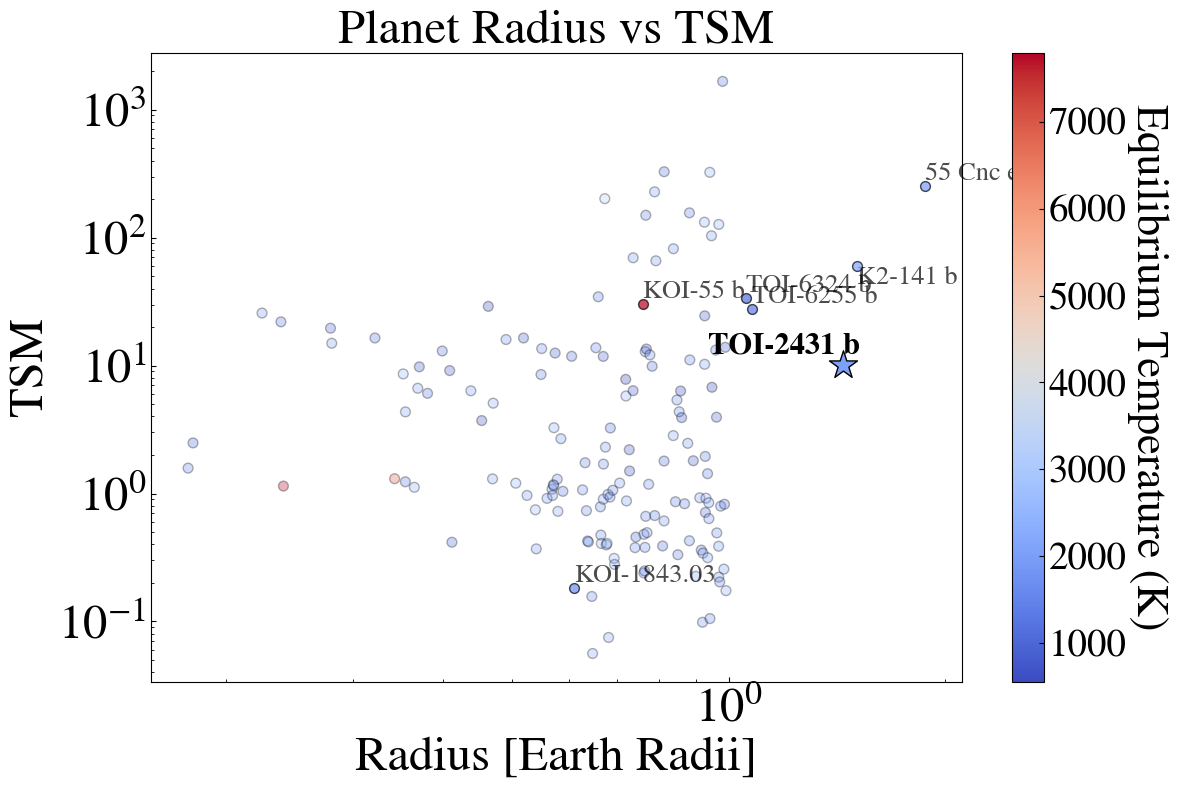

In [19]:
#We plot the TSM values.
#We then plot the results.
plt.figure(figsize=(12, 8))

scatter = plt.scatter(period, ESM, c = Teq, cmap = cmap, edgecolors = "k", norm = norm, zorder = 3, alpha = 0.3, s = 50)
cbar = plt.colorbar(scatter)
cbar.set_label('Equilibrium Temperature (K)', rotation=270, labelpad=30, fontsize = 32)
cbar.solids.set_alpha(1)
cbar.ax.tick_params(labelsize = 28)

#Now we also add labels to each datapoint.
for i, txt in enumerate(names):
    # if txt != "--":
    if txt != "--" and (txt == "K2-137 b" or txt == "K2-141 b" or txt == "TOI-6255 b" or txt == "KOI-55 b" or 
                        txt == "LHS 3844 b" or txt == "55 Cnc e" or txt == "TOI-2109 b" or txt == "TOI-6324 b" or
                        txt == "KOI-1843.03" or txt == "TOI-2431 b"):
        
        if txt == "K2-141 b":
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='top', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "55 Cnc e":
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "TOI-2109 b":
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "TOI-6255 b":
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)
            
        elif txt == "TOI-6324 b":
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "KOI-1843.03":
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)

        elif txt == "KOI-55 b":
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)
        
        elif txt == "TOI-2431 b":
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        marker = "*", norm = norm, zorder = 4, alpha = 1.0, s = 450)
            plt.text(pl_radius[i]+0.08, TSM[i]+1, txt, fontsize = 22, ha='right', va='bottom', zorder = 5, weight = "bold", alpha = 1.0)
        
        else:
            plt.text(pl_radius[i], TSM[i], txt, fontsize = 19, ha='left', va='bottom', zorder = 4, alpha = 0.7)
            plt.scatter(pl_radius[i], TSM[i], c = [Teq[i]], cmap = cmap, edgecolors = "k", 
                        norm = norm, zorder = 4, alpha = 0.7, s = 50)
        # if txt == "TOI-6255 b":
        #     plt.text(pl_radius[i], ESM[i], txt, fontsize = 9, ha='left', va='bottom', zorder = 4, alpha = 0.5)
        # else:
        #     plt.text(pl_radius[i], ESM[i], txt, fontsize = 9, ha='right', va='bottom', zorder = 4, alpha = 0.5)

#We add the labels and title
plt.title("Planet Radius vs TSM", fontsize = 35)
plt.xlabel("Radius [Earth Radii]", fontsize = 35)
plt.ylabel("TSM", fontsize = 35)
plt.xscale("log")
plt.yscale("log")
plt.tick_params(axis = 'both', labelsize = 35)
# plt.grid(True, zorder = 1)
plt.tight_layout()
plt.savefig("TSM_plot_radius", dpi = 500)
plt.show()